# Based on Yu et al. 2024

In [7]:
import torch

import matplotlib.pyplot as plt


current_device = torch.cuda.current_device()
print(torch.cuda.get_device_name(current_device))

NVIDIA GeForce GTX 960


In [8]:
from nn_helper import MyDataset

train_dataset = MyDataset("data/dataset_train_2.csv")
test_dataset = MyDataset("data/dataset_test_2.csv")

In [9]:
from nn_models import NNYuEtAl

num_sensors = 6
input_size = num_sensors * 2

model = NNYuEtAl(input_size)

batch_size = 8
model.info(batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
NNYuEtAl                                 [8, 2]                    --
├─Conv1d: 1-1                            [8, 20, 10]               80
├─BatchNorm1d: 1-2                       [8, 20, 10]               40
├─MaxPool1d: 1-3                         [8, 20, 5]                --
├─Conv1d: 1-4                            [8, 10, 3]                610
├─BatchNorm1d: 1-5                       [8, 10, 3]                20
├─MaxPool1d: 1-6                         [8, 10, 1]                --
├─Flatten: 1-7                           [8, 10]                   --
├─LSTM: 1-8                              [8, 20]                   2,560
├─LSTM: 1-9                              [8, 20]                   3,360
├─Linear: 1-10                           [8, 2]                    42
Total params: 6,712
Trainable params: 6,712
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.97
Input size (MB): 0.00
Forward/backward p

Loss at epoch 000: train_loss = 1196.843507 / val_loss = 990.345464
Loss at epoch 010: train_loss = 59.794009 / val_loss = 34.758814
Loss at epoch 020: train_loss = 36.780299 / val_loss = 14.135454
Loss at epoch 030: train_loss = 27.376213 / val_loss = 12.433085
Loss at epoch 040: train_loss = 29.206049 / val_loss = 18.021715
Loss at epoch 050: train_loss = 34.796753 / val_loss = 0.792430
Loss at epoch 060: train_loss = 27.076146 / val_loss = 10.545184
Loss at epoch 070: train_loss = 32.663796 / val_loss = 8.743416
Loss at epoch 080: train_loss = 25.149963 / val_loss = 27.038697
Loss at epoch 090: train_loss = 25.791643 / val_loss = 19.739475
Loss at epoch 100: train_loss = 25.381853 / val_loss = 18.964179
Loss at epoch 110: train_loss = 29.901747 / val_loss = 12.680481
Loss at epoch 120: train_loss = 29.141528 / val_loss = 7.331112
Loss at epoch 130: train_loss = 36.331799 / val_loss = 1.555291
Loss at epoch 140: train_loss = 27.726304 / val_loss = 16.114035
Loss at epoch 150: train_l

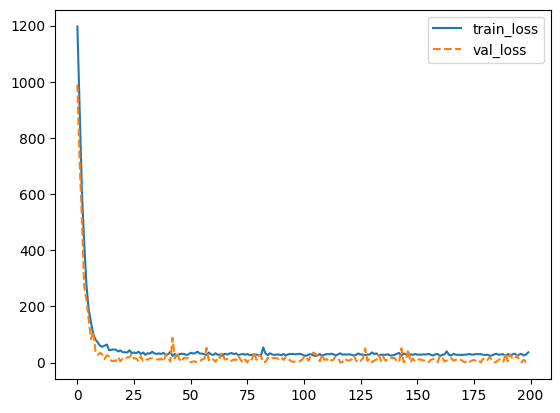

In [10]:
from nn_train import train_model

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=2e-2)
history = train_model(model, train_dataset, loss_fn, optimizer, current_device, epochs=200, validation_split=0.2, batch_size=batch_size, lambda1=0.02, lambda2=0.01)

# Plot history
plt.figure()

epochs = range(len(history["train_loss"]))
plt_list = [["train_loss", "-"], ["val_loss", "--"]]

for name, style in plt_list:
    plt.plot(epochs, history[name], style, label=name)
plt.legend(loc="best")

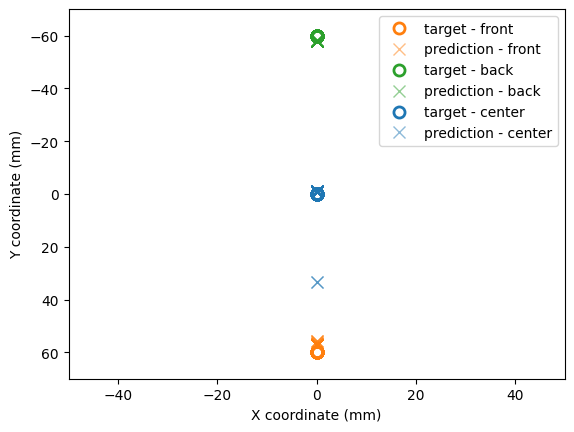

In [11]:
from nn_helper import locations
from nn_train import test_model

fig, ax, errors = test_model(model, test_dataset, locations)

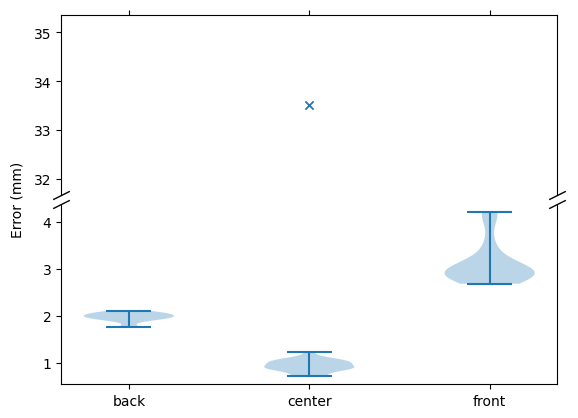

In [12]:
from nn_train import plot_violins_from_error

fig, ax = plot_violins_from_error(errors, threshold=30)